In [41]:
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
import numpy as np
import copy
import math
%matplotlib inline

In [42]:
class Moving_Point:
    
    acceleration=10
    timestep=0.1
    
    def __init__(self,height):
        self.previous_velocity=0
        self.current_velocity=0
        self.time=Moving_Point.timestep
        self.distance_crossed=0
        self.height=height
        self.t_max=math.sqrt(2*self.height/10)
        self.v_max=-self.t_max*10

    
    def advance_step(self,timestep):
        new_velocity=0
        a=Moving_Point.acceleration
        h=Moving_Point.timestep
        v_max=self.v_max
        
        if self.distance_crossed < self.height and  self.current_velocity <= 0:
            new_velocity=self.current_velocity-a*h
            self.distance_crossed+=abs(self.current_velocity)*h+0.5*a*(h)**2
            if self.distance_crossed > self.height:
                self.distance_crossed=self.height
                new_velocity=-v_max
                self.current_velocity=0
        elif self.current_velocity > 0 :
                new_velocity=self.current_velocity-a*h
                self.distance_crossed-=abs(self.current_velocity)*h-0.5*a*(h)**2
        self.previous_velocity=self.current_velocity
        self.current_velocity=new_velocity
        self.time+=h
        return self.current_velocity,self.previous_velocity,self.height-self.distance_crossed,self.time
    
   
    

In [43]:
p=Moving_Point(100)
p2=Moving_Point(200)

In [44]:
p.v_max

-44.721359549995796

In [45]:
distances=[]
v_current=[]
v_previous=[]
nb_of_training_points=400
for i in range(nb_of_training_points):
    if i>nb_of_training_points/2:
        current_speed,prev_speed,distance,time = p.advance_step(p.time)
    #print("Distance from collider is: {0}, current velocity is :{1}, previous velocity is : {2}, time :{3}".format(distance
    #                                                                                                   ,current_speed,
     #                                                                                                 prev_speed,time))
    else:
        p2.height=200
        current_speed,prev_speed,distance,time = p2.advance_step(p2.time)

    v_previous.append(prev_speed)
    v_current.append(current_speed)
    distances.append(distance)

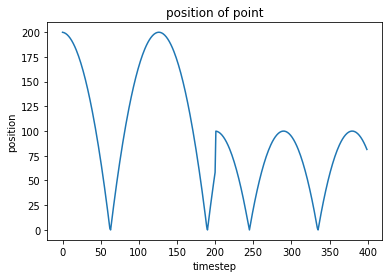

In [46]:
plt.title('position of point')
plt.xlabel('timestep')
plt.ylabel('position')
plt.plot(distances)

In [47]:
len(v_previous)

400

In [48]:
v_2_previous=[]
v_2_previous=copy.copy(v_previous)
v_2_previous.insert(0,0)
v_2_previous.pop()
len(v_2_previous)

400

In [49]:
# Convert to numpy array for torch #
v_current=np.array(v_current)
v_previous=np.array(v_previous)
v_2_previous=np.array(v_2_previous)
distances=np.array(distances)


In [50]:

X=np.array([v_2_previous,v_previous,distances]).T
Y=np.array(v_current).T


In [51]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [52]:
# Convert to pytorch tensors

X_tensor=torch.from_numpy(X).type(torch.FloatTensor)
Y_tensor=torch.from_numpy(Y).type(torch.FloatTensor)

# Convert to pytorch variables
X_variable=Variable(X_tensor,requires_grad=False)
Y_variable=Variable(Y_tensor,requires_grad=False)


In [53]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.fc3 = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))      # activation function for hidden layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [54]:
# Set hyperparameters #
net = Net(n_feature=3, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.00001,momentum=0.9)
loss_func = torch.nn.MSELoss(size_average=True)  



Net(
  (fc1): Linear(in_features=3, out_features=10)
  (fc2): Linear(in_features=10, out_features=10)
  (fc3): Linear(in_features=10, out_features=1)
)


In [59]:
nb_of_epochs=1000
batch_size=100
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,X_variable.size(0),batch_size):
        out = net(X_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, Y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
    
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        sum_loss+=loss.data[0]
        optimizer.step()        # apply gradients
    print("Epoch :",t, "Loss:",sum_loss)


Epoch : 0 Loss: 0.16612396202981472
Epoch : 1 Loss: 0.16610125079751015
Epoch : 2 Loss: 0.16604160144925117
Epoch : 3 Loss: 0.16592079028487206
Epoch : 4 Loss: 0.1658051274716854
Epoch : 5 Loss: 0.16568215191364288
Epoch : 6 Loss: 0.1655951738357544
Epoch : 7 Loss: 0.16551549173891544
Epoch : 8 Loss: 0.165416169911623
Epoch : 9 Loss: 0.1653118133544922
Epoch : 10 Loss: 0.16516660153865814
Epoch : 11 Loss: 0.1651179175823927
Epoch : 12 Loss: 0.1650498639792204
Epoch : 13 Loss: 0.1649416945874691
Epoch : 14 Loss: 0.16483158618211746
Epoch : 15 Loss: 0.16472026892006397
Epoch : 16 Loss: 0.1646276582032442
Epoch : 17 Loss: 0.16455434821546078
Epoch : 18 Loss: 0.1644693687558174
Epoch : 19 Loss: 0.1643649209290743
Epoch : 20 Loss: 0.16426864825189114
Epoch : 21 Loss: 0.16418010741472244
Epoch : 22 Loss: 0.1640898659825325
Epoch : 23 Loss: 0.16400171630084515
Epoch : 24 Loss: 0.16391625814139843
Epoch : 25 Loss: 0.163824163377285
Epoch : 26 Loss: 0.16373235173523426
Epoch : 27 Loss: 0.163602

In [56]:
## creating test data ###

p_test=Moving_Point(150)
distances_test=[]
v_current_test=[]
v_previous_test=[]
for i in range(1):
    current_speed,prev_speed,distance,time = p_test.advance_step(0)

    v_previous_test.append(prev_speed)

    v_current_test.append(current_speed)
    distances_test.append(distance)




    v_2_previous_test=[]
    v_2_previous_test=copy.copy(v_previous_test)
    v_2_previous_test.insert(0,0)
    v_2_previous_test.pop()    
        

# Convert to numpy array for torch #
v_current_test=np.array(v_current_test)
v_previous_test=np.array(v_previous_test)
v_2_previous_test=np.array(v_2_previous_test)
distances_test=np.array(distances_test)
X_test=np.array([v_2_previous_test,v_previous_test,distances_test]).T
X_tensor_test=torch.from_numpy(X_test).type(torch.FloatTensor)
X_variable_test=Variable(X_tensor_test,requires_grad=False)
Y_predict=net(X_variable_test)
v_current_speed=Y_predict.data[0]
len(Y_predict)

1

In [57]:
v_current_speed


-0.9252
[torch.FloatTensor of size 1]

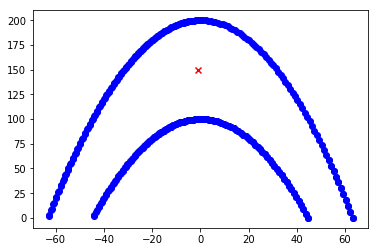

In [58]:
plt.scatter(Y_predict.data,distances_test,marker='x',color='r')
plt.scatter(v_current,distances,marker='o',color='b')
